<a href="https://colab.research.google.com/github/UN-GCPDS/python-gcpds.localbiplot/blob/main/docs/source/notebooks/01-module%20example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando la librería

In [49]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.localbiplot.git --quiet

  Preparing metadata (setup.py) ... done


## Agregando todolo necesario para ejecutar nuestro codigo

Agregamos la librerias necesarias como numpy, pandas  y scikit learn.

In [50]:
# #librerias a importar
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler


Una vez  descargada la libreria procedemos a utilizarla dentro de nuestro codigo.


In [51]:
import gcpds.localbiplot as lb


## Escribiendo función para datos sintéticos

Dado que este caso de uso es una aplicacion general, procedemos a generar una base de datos sintentica utilizando una media y covarianzas predefinidas

In [52]:



def generate_samples(mean, covariance, num_samples=500, standardize=True):
        """
        Generate random samples based on mean and covariance.

        Parameters:
        - mean: list | np.ndarray
          1-D array_like, of length N. Mean of the N-dimensional distribution.

        - covariance: list | np.ndarray
          2-D array_like, of shape (N, N)
          Covariance matrix of the distribution. It must be symmetric and positive-semidefinite for proper sampling.
        - num_samples: int | tuple of ints
        - standardize: Whether to standardize the generated samples. Default is True.

        Returns: list | np.ndarray
        - samples:
          Drawn samples, of shape size, if that was provided. If not, the shape is (N,)
        Generated samples.
        """

        np.random.seed(123)
        samples = np.random.default_rng(seed=123).multivariate_normal(mean, covariance, num_samples)

        if standardize:
            scaler = MinMaxScaler()
            samples = scaler.fit_transform(samples)

        return samples






## Generando los datos

In [53]:
# Parameters
n_samples = 500
n_features = 5
n_clusters = 3

np.random.seed(123)

# Initialize empty array for the data
data = np.zeros((n_samples * n_clusters, n_features))


mean_5 = [[0.1, 0.05, 22.2, 92.4, 102],
         [12.3,  23.8,  12.2, 14.4, 10],
         [-12.3, 15.8, 9.2, -9.4, 9],]


covariance_5 = [[[3.    , 2.45  , 0.84  , 0.12  , 0.68  ],
                [2.45  , 2.25  , 0.    , 0.162 , 0.102 ],
                [0.84  , 0.    , 1.    , 0.36  , 0.034 ],
                [0.12  , 0.162 , 0.36  , 1.44  , 0.0816],
                [0.68  , 0.102 , 0.034 , 0.0816, 2.89  ]],


                  [[7.0, -5, 2, -5.2, -0.1],
                  [-5,  3.5, -0.4, -0.3, -0.2],
                  [2, -0.4, 3.0, -0.2, -0.1],
                  [-5.2, -0.3, -0.2, 5.0, -0.1],
                  [-0.1, -0.2, -0.1, -0.1, 8.0]],


                [[8.,    0.2   , -1.6   , -2.352 , -3.0 ],
                [0.2,   2.25  , 1.2   , 1.62  , 2.295 ],
                [-1.6,    1.2   , 6.    , 0.84  , 1.564 ],
                [-2.352,  -1.62  , 0.84  , 4.44  , 2.0],
                [-3.0 , 2.295 , -1.564 , 2.0, 3.89  ]]]



# Define mean and covariance for each cluster
for i in range(n_clusters):

    cluster_data =  generate_samples(mean_5[i], covariance_5[i], standardize=False)
    #print(np.cov(cluster_data.T) )
    data[i * n_samples:(i + 1) * n_samples, :] = cluster_data

#target variable generation
class_synth = 3
nc = 500
ydata = np.empty(shape=[nc*class_synth],dtype=np.int8)
for i in range(class_synth):
  ydata[i*nc :(i+1)*nc] = i

Convertimos los datos a pandas dataframe, que  es el tipo de dato de entrada esperado  por la librería.

In [54]:
#convertir datos a Dataframe
Xdata = pd.DataFrame(data, columns=['f1', 'f2','f3', 'f4', 'f5' ])

print(Xdata.shape, ydata.shape)

(1500, 5) (1500,)


Ejecutamos el método

Calculamos el localbiplot para los datos sintéticos. se logra apreciar un grafico de correlaciones  a nivel de variables, indicando las correlaciones de todo el conjunto de datos, de cada cluster y de las matrices biplot generadas para las variables de cada subconjunto de datos.

variance explained: [0.84775919 0.13367759 0.0118387  0.00553754 0.00118698]
Index(['f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')


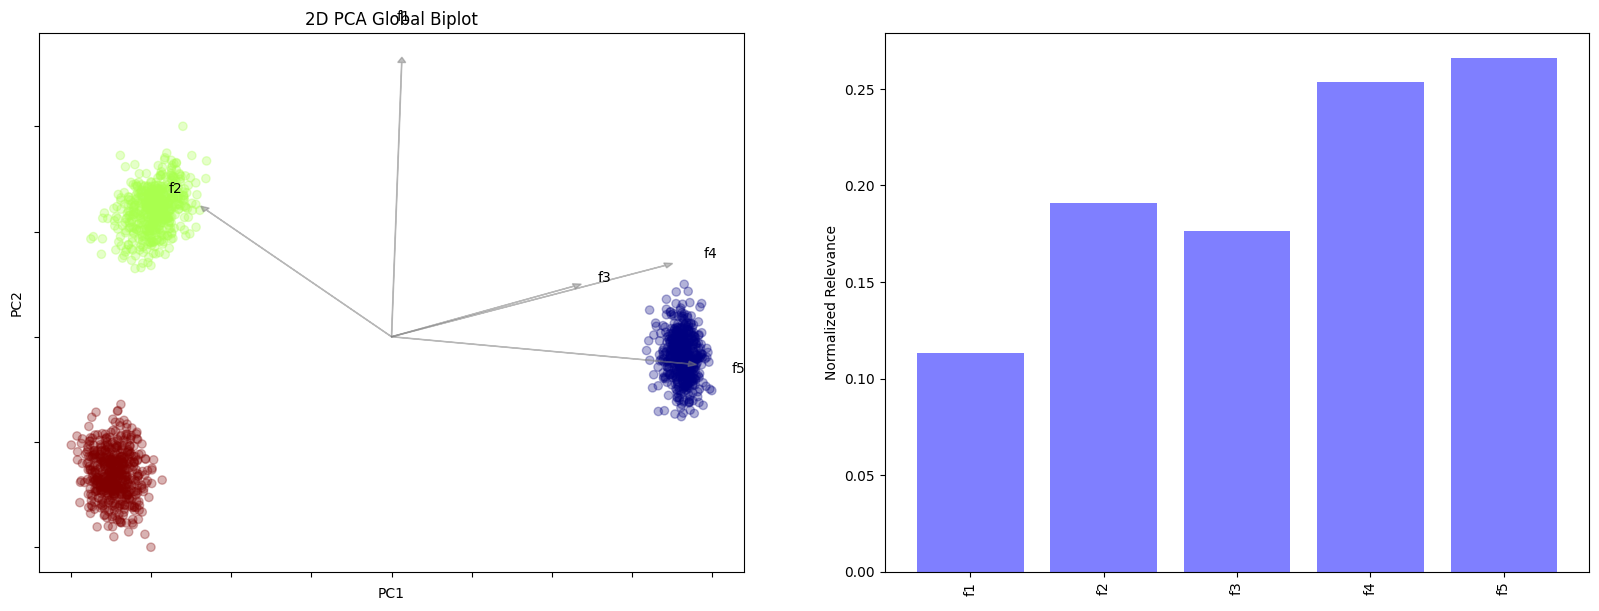

Dimensionality Reduction...
Affine Transformation...
1/3
(500, 5)
variance explained: [0.41675491 0.22420651 0.2185841  0.12468377 0.01577072]
plot 1-th group
Index(['f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')
Saving figure synth_local_bip
2/3
(500, 5)
variance explained: [0.39552911 0.23471258 0.17886436 0.13707245 0.05382149]
plot 2-th group
Index(['f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')
Saving figure synth_local_bip
3/3
(500, 5)
variance explained: [0.44720821 0.22011799 0.20531436 0.11685426 0.01050519]
plot 3-th group
Index(['f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')
Saving figure synth_local_bip


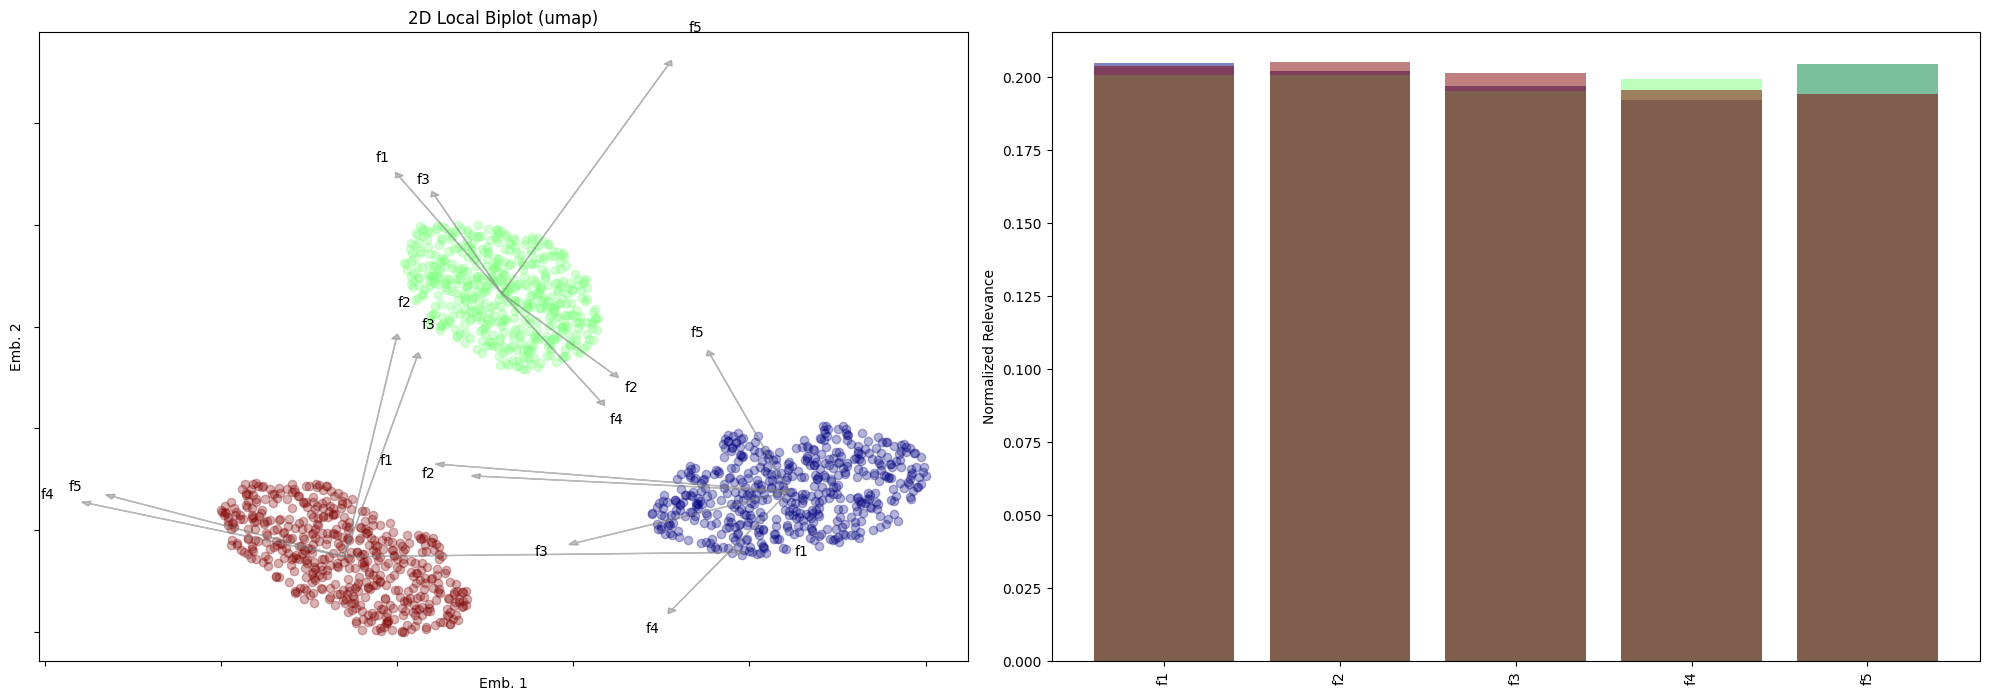

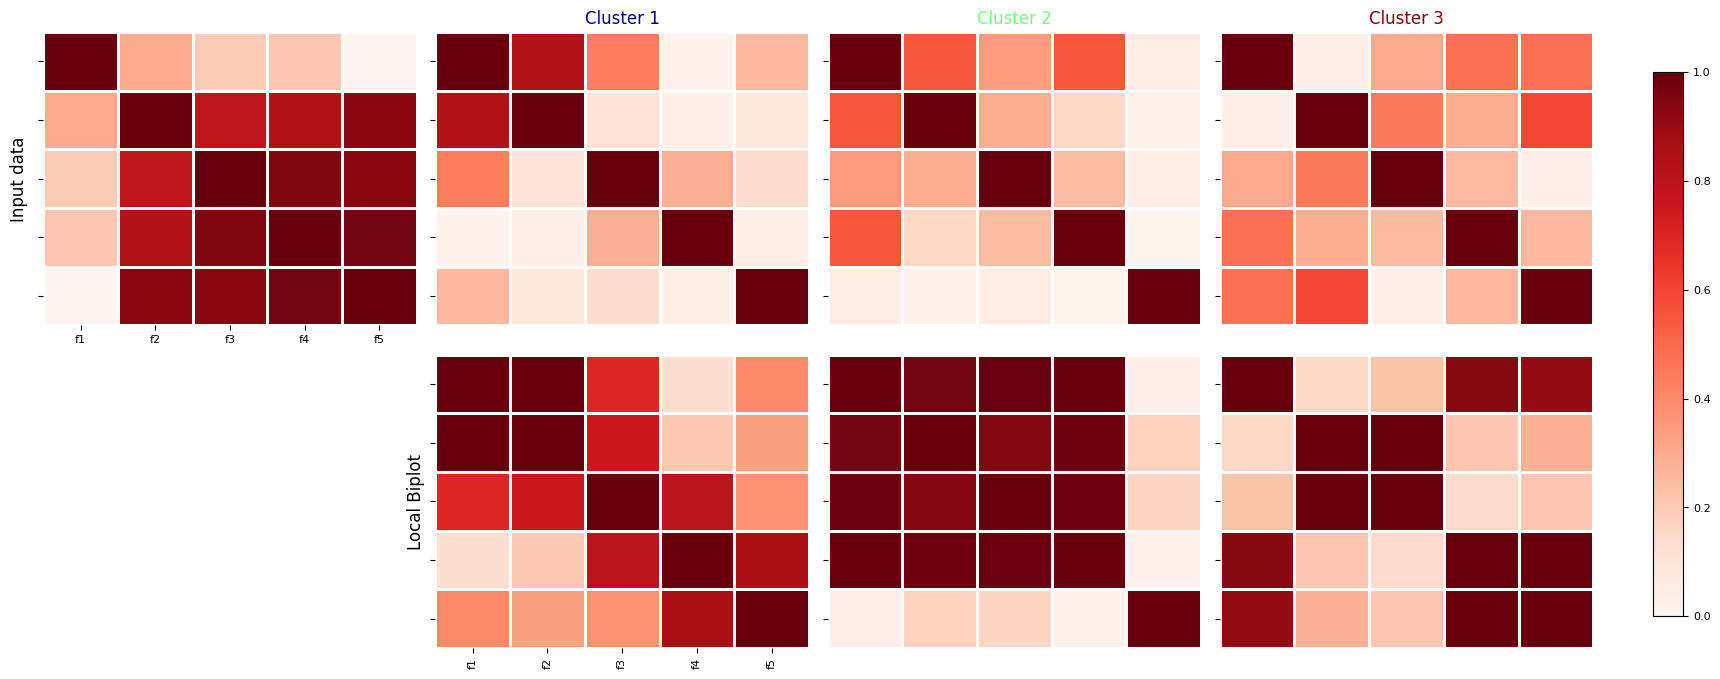

array([0, 0, 0, ..., 2, 2, 2], dtype=int8)

In [55]:
localbiplot = lb.LocalBiplot(affine_='rotation',redm='umap')
#global pca biplot
loading,rel_,score = localbiplot.biplot2D(Xdata,plot_=True,labels=ydata,loading_labels=Xdata.columns)
#local biplot
localbiplot.local_biplot2D(Xdata,y=ydata,plot_=True,loading_labels=Xdata.columns,  filename="synth_local_bip")

#Base de datos Pastos

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib as mpl

In [57]:
#ojo etiquetas
repo_url = "https://github.com/Jectrianama/Datasets_biplot.git"
repo_name = "Datasets_biplot"

# Check if the repository directory already exists
if not os.path.exists(repo_name):
  # Clone the repository if it doesn't exist
  !git clone -l -s $repo_url


!unzip -o /content/Datasets_biplot/PhenotypingData.zip


csv_path = '/content/PhenotypingData.csv' #database directory on collaborative disk according to prevously uploaded file

data = pd.read_csv(csv_path, sep = ';') #read csv file


Archive:  /content/Datasets_biplot/PhenotypingData.zip
  inflating: PhenotypingData.csv     
  inflating: __MACOSX/._PhenotypingData.csv  
  inflating: Climate.txt             
  inflating: __MACOSX/._Climate.txt  
  inflating: All_TDRdata.txt         
  inflating: __MACOSX/._All_TDRdata.txt  


#Download grass database

In [58]:
repo_url = "https://github.com/Jectrianama/Datasets_biplot.git"
repo_name = "Datasets_biplot"

# Check if the repository directory already exists
if not os.path.exists(repo_name):
  # Clone the repository if it doesn't exist
  !git clone -l -s $repo_url

!unzip -o /content/Datasets_biplot/PhenotypingData.zip


csv_path = '/content/PhenotypingData.csv' #database directory on collaborative disk according to prevously uploaded file
data = pd.read_csv(csv_path, sep = ';') #read csv file

Archive:  /content/Datasets_biplot/PhenotypingData.zip
  inflating: PhenotypingData.csv     
  inflating: __MACOSX/._PhenotypingData.csv  
  inflating: Climate.txt             
  inflating: __MACOSX/._Climate.txt  
  inflating: All_TDRdata.txt         
  inflating: __MACOSX/._All_TDRdata.txt  


#Rename and remove some dataframe columns

In [59]:
#data.info()
data.rename(columns={'FamKloon':'Famclone', 'Soort': 'Variety', 'GR_Rat':'G/R', 'Hue_val': 'H',
       'S_val' : 'S', 'V_val' : 'V', 'L_val' : 'L', 'a_val' : 'a*', 'b_val':'b*', 'I_val':'I' ,
       'G_R': 'G-R', 'G_B' : 'G-B', 'u_val': 'u*', 'v_val': 'v*'}, inplace=True)
data.drop(columns= ['Famclone', 'Code'	], inplace=True)#

In [60]:
np.unique(data['Date'])

array([130709, 130716, 130801, 130828, 130906])

In [61]:
# Suponiendo que Data_sel es un DataFrame de pandas
mapping = {

    130716: 1,
    130828: 2,
    130906: 3
}

data['Date'].replace(mapping, inplace=True)

replacing varieties 'Fa', 'Lp2n', 'Lp4n' to  1, 2, 3

In [62]:
data['Variety'].replace(['Fa', 'Lp2n', 'Lp4n'],
                        [1, 2, 3], inplace=True)


data = data.dropna().reset_index(drop=True)

data.loc[:,'CWSI'] += 0.0005 #esta columna tiene datos en ceros

In [63]:
np.unique(data['Date'])

array([1, 2, 3])

In [64]:
data = data[['Date', 'Variety', 'Rkap',  'R', 'G', 'B', 'RCC', 'GCC', 'BCC','ExG', 'ExG2', 'ExR','ExGR', 'GRVI', 'GBVI', 'BRVI', 'G/R', 'G-R', 'G-B', 'VDVI', 'VARI', 'MGRVI', 'CIVE', 'VEG','WI', 'H', 'S', 'V', 'I',  'L', 'a*', 'b*', 'ab', 'NDLab', 'u*', 'v*','uv', 'NDLuv','dT', 'CWSI','Score']]
#data = data[['Date', 'Variety', 'Rkap', 'RCC', 'ExR', 'GCC', 'ExG2', 'G/R', 'GRVI', 'MGRVI', 'VARI', 'VDVI', 'VEG', 'H', 'NDLab','CWSI', 'Score']]

In [65]:

#target = data ['Score']
date= data['Date']

Xdata = data.iloc[:, 3:41].copy() #.iloc[:, 3:40].copy()
#ydata = np.uint8(data['Score'])
ydata = data['Score']


Dimensionality Reduction...
Performing clustering...
(3174,) - [0 1 2 3]
Affine Transformation...
1/4
(651, 38)
variance explained: [5.19871801e-01 2.34846121e-01 1.70186370e-01 5.48736209e-02
 1.55434479e-02 2.74644884e-03 1.14178767e-03 3.91118519e-04
 2.39631110e-04 9.16536949e-05 3.15005695e-05 2.66756070e-05
 7.56034320e-06 1.05437192e-06 7.60602621e-07 1.96080844e-07
 1.36325725e-07 5.46285640e-08 3.33884856e-08 1.27773443e-08
 9.99472057e-09 3.51631755e-09 8.21008622e-10 1.84701666e-10
 7.61062405e-11 9.27730191e-12 2.18081304e-12 4.22188180e-13
 8.57117977e-17 5.35247035e-17 3.99149800e-17 1.80411056e-17
 1.36691949e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
plot 1-th group
Index(['R', 'G', 'B', 'RCC', 'GCC', 'BCC', 'ExG', 'ExG2', 'ExR', 'ExGR',
       'GRVI', 'GBVI', 'BRVI', 'G/R', 'G-R', 'G-B', 'VDVI', 'VARI', 'MGRVI',
       'CIVE', 'VEG', 'WI', 'H', 'S', 'V', 'I', 'L', 'a*', 'b*', 'ab', 'NDLab',
       'u*', 'v*', 'uv', 'NDLuv', 'dT', '

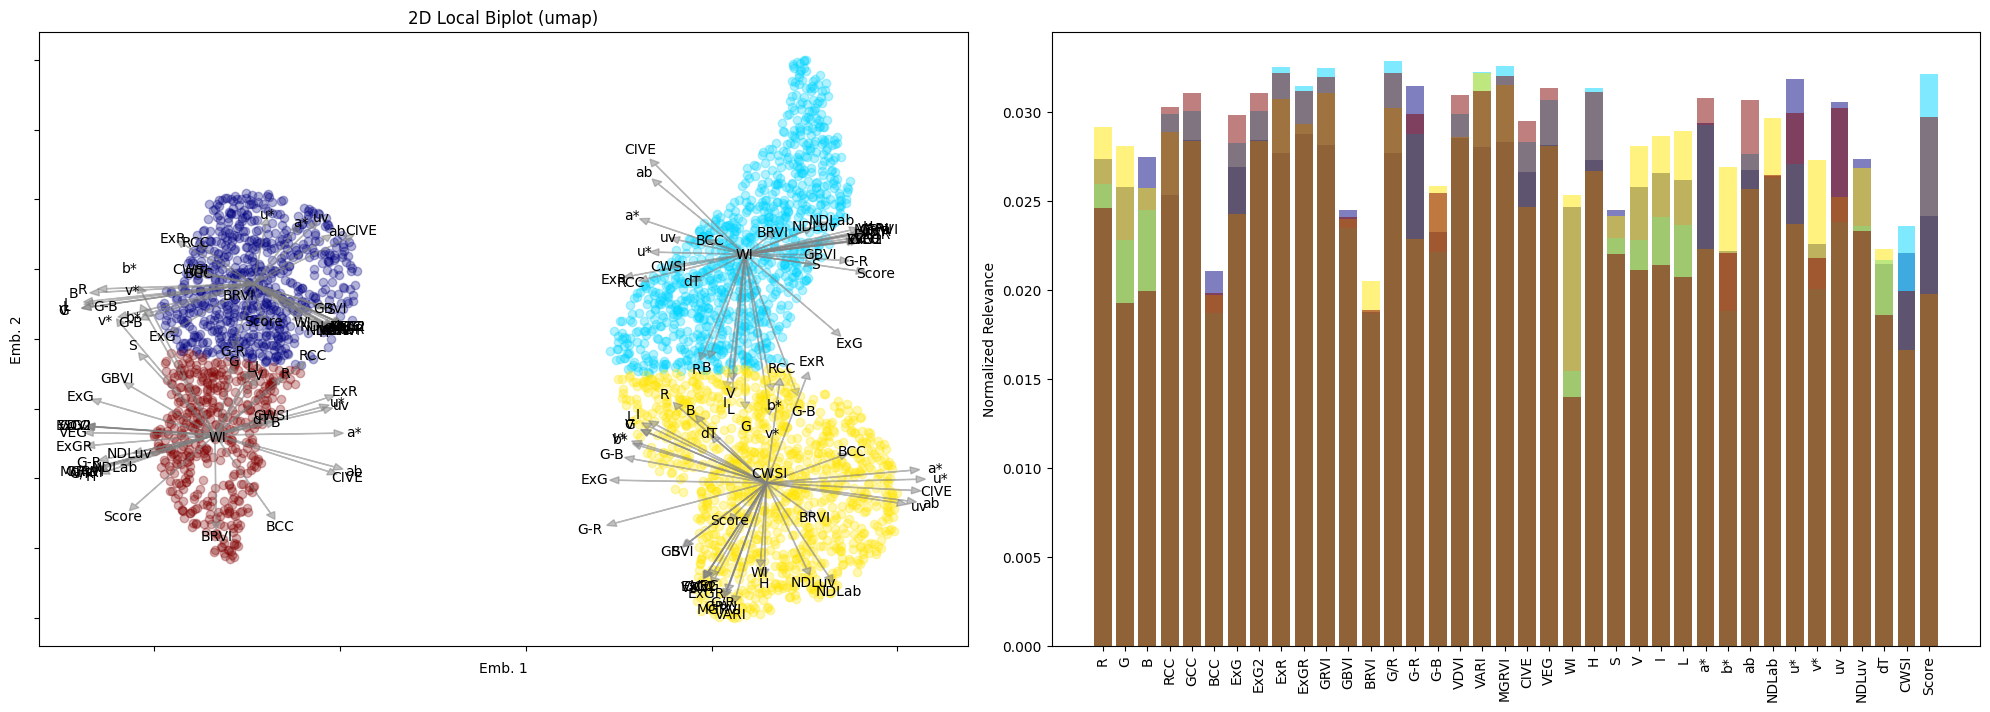

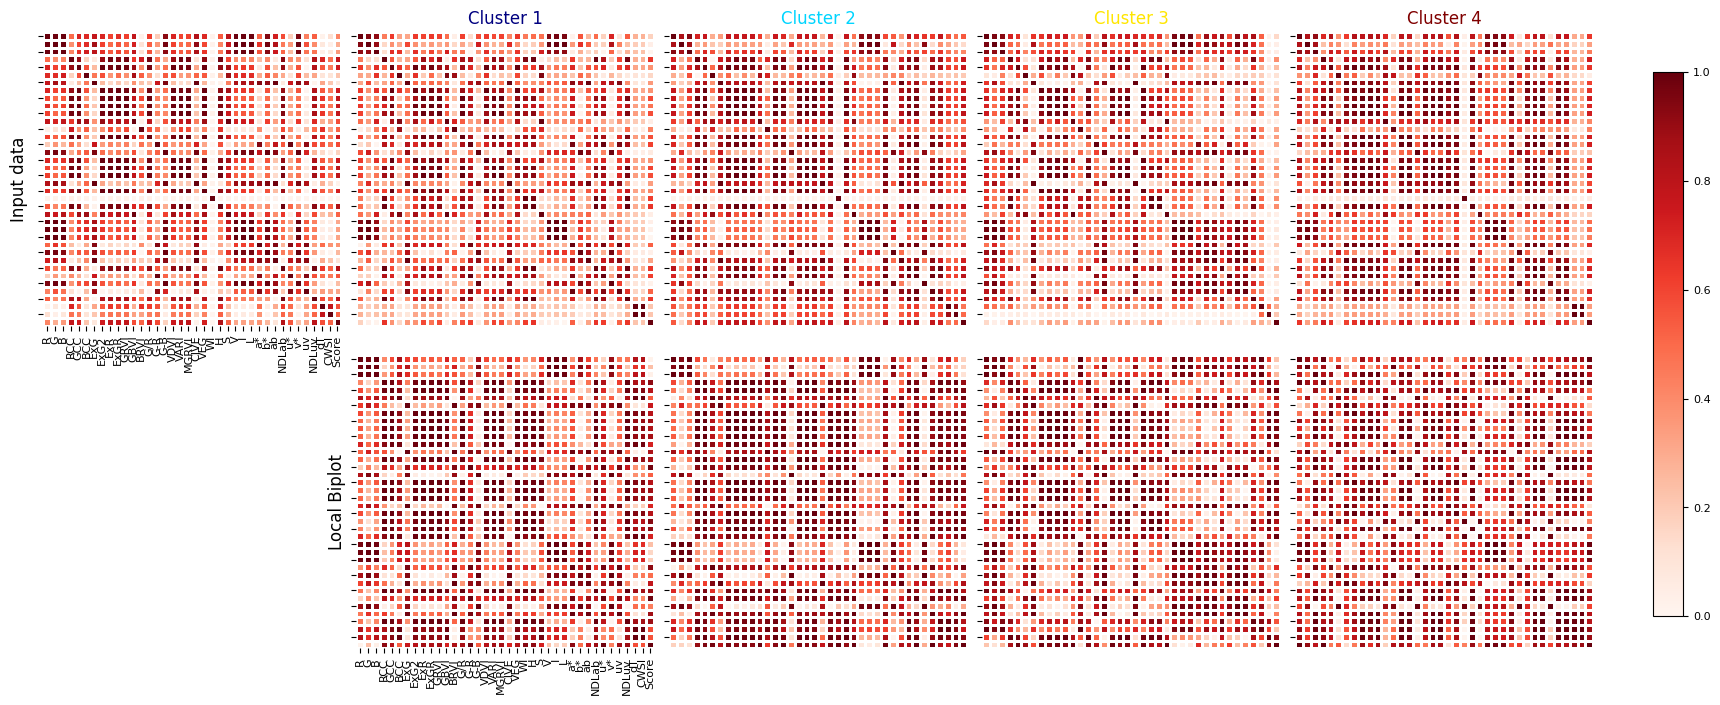

variance explained: [6.39121063e-01 2.69349187e-01 3.38774759e-02 2.18064830e-02
 2.00200290e-02 9.44095643e-03 2.34908027e-03 2.09751123e-03
 8.46503962e-04 3.74001562e-04 3.21045129e-04 2.37261188e-04
 6.00033656e-05 3.95705017e-05 2.99323186e-05 7.99471294e-06
 6.78819824e-06 5.91886110e-06 5.44298273e-06 1.46950559e-06
 1.31023212e-06 4.06118505e-07 3.39107276e-07 1.26211938e-07
 6.17343716e-08 3.06789845e-08 5.83047591e-09 1.84310912e-09
 9.79241743e-11 1.16991929e-16 3.54149619e-17 2.23678047e-17
 1.19268967e-17 1.13349085e-17 2.58481734e-18 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
Index(['R', 'G', 'B', 'RCC', 'GCC', 'BCC', 'ExG', 'ExG2', 'ExR', 'ExGR',
       'GRVI', 'GBVI', 'BRVI', 'G/R', 'G-R', 'G-B', 'VDVI', 'VARI', 'MGRVI',
       'CIVE', 'VEG', 'WI', 'H', 'S', 'V', 'I', 'L', 'a*', 'b*', 'ab', 'NDLab',
       'u*', 'v*', 'uv', 'NDLuv', 'dT', 'CWSI', 'Score'],
      dtype='object')
Saving figure grass_classic_bip


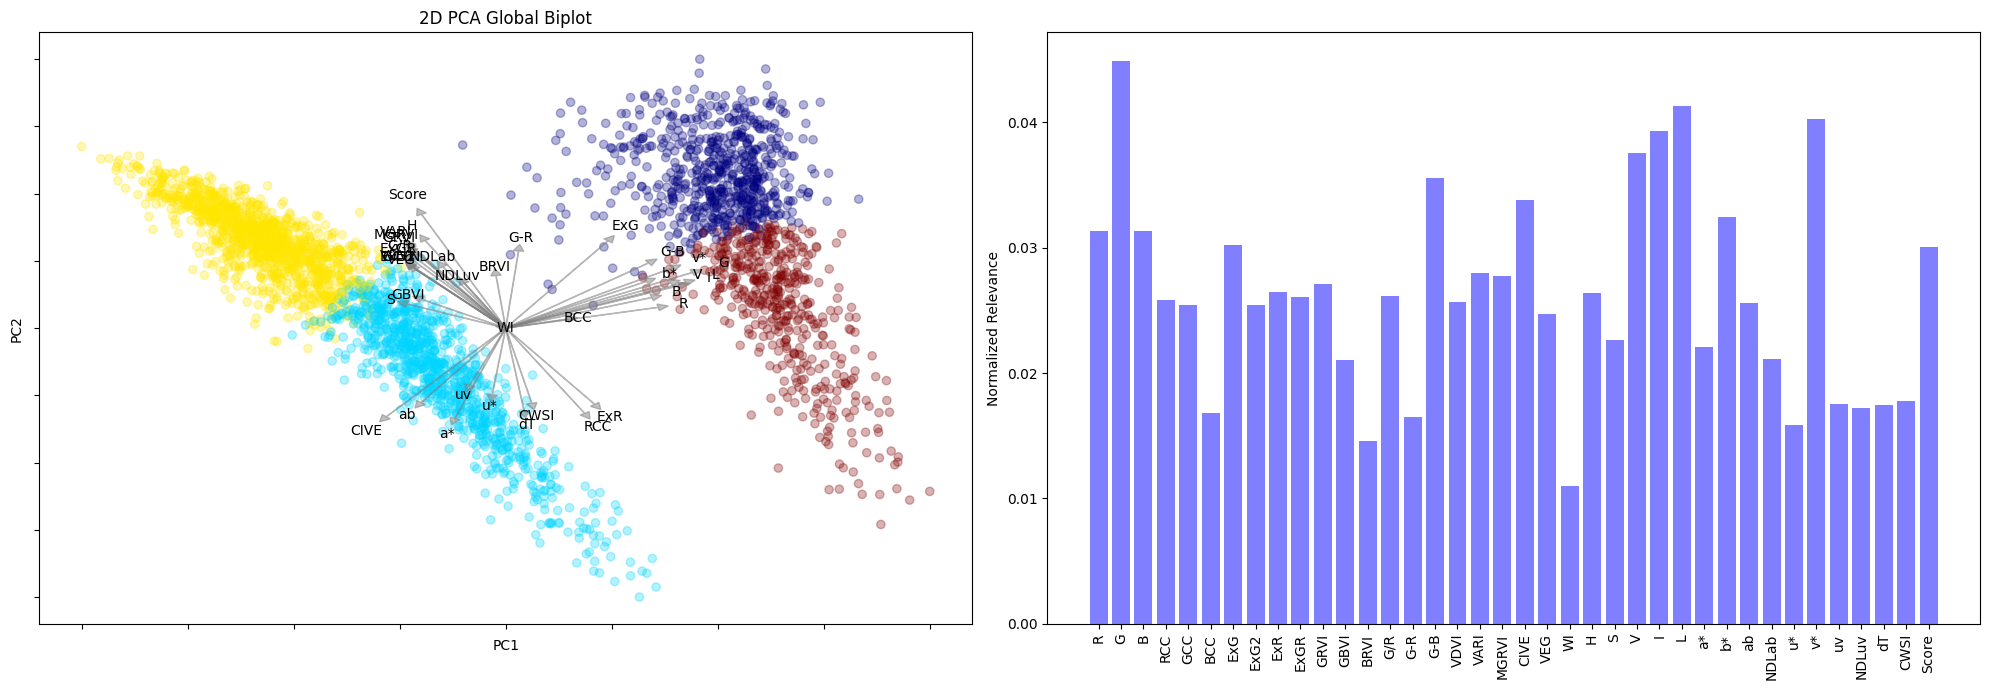

In [66]:
localbiplot = lb.LocalBiplot(affine_='rotation',redm='umap')
#global pca biplot
#loading,rel_,score = localbiplot.biplot2D(Xdata,plot_=True,labels=ydata,loading_labels=Xdata.columns, filename="grass_classic_bip")

#local biplot
group = localbiplot.local_biplot2D(Xdata,y=4,plot_=True,loading_labels=Xdata.columns, filename="grass_local_bip")
#global pca biplot
loading,rel_,score = localbiplot.biplot2D(Xdata,plot_=True,labels=group,loading_labels=Xdata.columns, filename="grass_classic_bip")




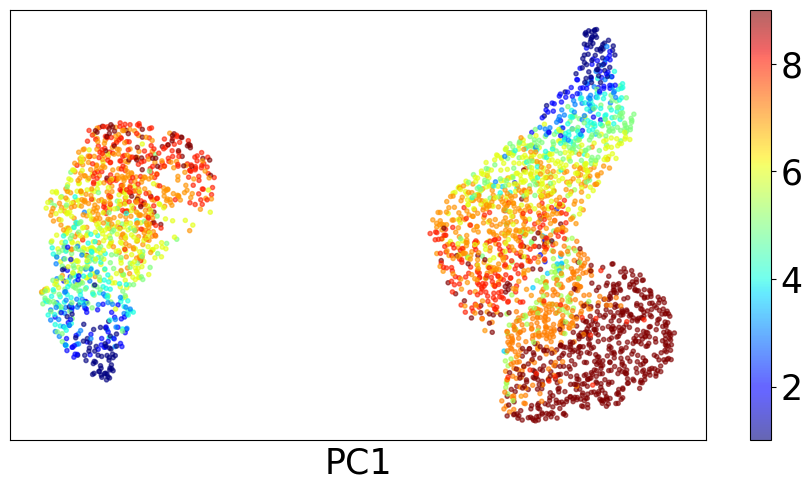

In [67]:
C_ = len(np.unique(ydata))
cmap_ = mpl.colormaps['jet'].resampled(C_)
cmap_ = cmap_(range(C_))
plt.figure(figsize =(9,5))
plt.scatter(localbiplot.Zr[:,0],localbiplot.Zr[:,1], c=ydata, cmap='jet', alpha=0.6, marker='.')

plt.yticks([])
plt.xticks([])
plt.xlabel('PC1', fontsize=25)
cbar = plt.colorbar()
tick_font_size = 25
cbar.ax.tick_params(labelsize=tick_font_size)
plt.tight_layout()
plt.savefig('umap_score.pdf', bbox_inches='tight', dpi=300)
plt.show()